COFFEE SHOP EMPLOYEE SCHEDULING OPTIMIZATION

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(3230)

MATHEMATICAL FORMULATION

In [2]:

formulation = """
SETS:
  E = Set of employees (e = 1, 2, ..., 15)
  S = Set of shifts (s = Monday 7-11AM, Monday 11AM-3PM, ..., Sunday 7-12AM)
  K = Set of skills (k = Barista, Cashier, Shift Lead, Food Prep, Cleaner)

PARAMETERS:
  w_e = Hourly wage of employee e ($/hour)
  h_s = Duration of shift s (hours)
  p_es = Preference score of employee e for shift s [1-5]
  a_es = Availability: 1 if employee e can work shift s, 0 otherwise
  skill_ek = 1 if employee e has skill k, 0 otherwise
  req_sk = Number of employees with skill k required for shift s
  maxH_e = Maximum weekly hours for employee e (hours)
  λ = Weight parameter for cost vs. preference trade-off [0,1]

DECISION VARIABLES:
  x_es ∈ {0,1} = 1 if employee e is assigned to shift s, 0 otherwise

OBJECTIVE FUNCTION:
  Minimize: λ × (Total Cost) - (1 - λ) × (Total Preference)
  
  Where:
    Total Cost = Σ_e Σ_s (x_es × w_e × h_s)
    Total Preference = Σ_e Σ_s (x_es × p_es)

CONSTRAINTS:
  1. Skill Coverage: Σ_e (x_es × skill_ek) ≥ req_sk  ∀s ∈ S, ∀k ∈ K
     (Each shift must have enough employees with required skills)
  
  2. Availability: x_es ≤ a_es  ∀e ∈ E, ∀s ∈ S
     (Employees can only work when they are available)
  
  3. Maximum Hours: Σ_s (x_es × h_s) ≤ maxH_e  ∀e ∈ E
     (Total hours cannot exceed maximum weekly hours)
  
  4. No Overlap: Σ_{s∈Overlap(t)} x_es ≤ 1  ∀e ∈ E, ∀t ∈ Time periods
     (Employee cannot work overlapping shifts)
"""

print(formulation)


SETS:
  E = Set of employees (e = 1, 2, ..., 15)
  S = Set of shifts (s = Monday 7-11AM, Monday 11AM-3PM, ..., Sunday 7-12AM)
  K = Set of skills (k = Barista, Cashier, Shift Lead, Food Prep, Cleaner)

PARAMETERS:
  w_e = Hourly wage of employee e ($/hour)
  h_s = Duration of shift s (hours)
  p_es = Preference score of employee e for shift s [1-5]
  a_es = Availability: 1 if employee e can work shift s, 0 otherwise
  skill_ek = 1 if employee e has skill k, 0 otherwise
  req_sk = Number of employees with skill k required for shift s
  maxH_e = Maximum weekly hours for employee e (hours)
  λ = Weight parameter for cost vs. preference trade-off [0,1]

DECISION VARIABLES:
  x_es ∈ {0,1} = 1 if employee e is assigned to shift s, 0 otherwise

OBJECTIVE FUNCTION:
  Minimize: λ × (Total Cost) - (1 - λ) × (Total Preference)

  Where:
    Total Cost = Σ_e Σ_s (x_es × w_e × h_s)
    Total Preference = Σ_e Σ_s (x_es × p_es)

CONSTRAINTS:
  1. Skill Coverage: Σ_e (x_es × skill_ek) ≥ req_sk  ∀s ∈ 

DATA GENERATION

In [3]:

print("\n Defining Skills")
skills = ['Barista', 'Cashier', 'Shift Lead', 'Food Prep', 'Cleaner']
print(f"Skills available: {skills}")

print("\n Generating Shifts")

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_slots = [
    ('7-11AM', 7, 11, 4),
    ('11AM-3PM', 11, 15, 4),
    ('3-7PM', 15, 19, 4),
    ('7-12AM', 19, 24, 5)
]

# Generate shifts
shifts = []
shift_hours = {}
shift_times = {}

for day in days:
    for slot_name, start, end, hours in time_slots:
        shift_name = f"{day} {slot_name}"
        shifts.append(shift_name)
        shift_hours[shift_name] = hours
        shift_times[shift_name] = (day, start, end)

print(f"Total shifts per week: {len(shifts)}")
print(f"Sample shifts: {shifts[:4]}")
print(f"\nShift durations:")
for shift in shifts[:4]:
    print(f"  {shift}: {shift_hours[shift]} hours")

print("\n Generating Employee Data")

num_employees = 15
employees = {}

# creating employees
employee_names = [
    "Alice", "Bob", "Charlie", "Diana", "Ethan",
    "Fiona", "George", "Hannah", "Isaac", "Julia",
    "Kevin", "Laura", "Mike", "Nina", "Oscar"
]

# skill pool to make sure there is proper coverage
skill_pool = {
    'Barista': ['Alice', 'Bob', 'Charlie', 'Diana', 'Ethan', 'Fiona', 'George', 'Hannah', 'Isaac', 'Julia'],
    'Cashier': ['Alice', 'Bob', 'Charlie', 'Diana', 'Ethan', 'Fiona', 'Kevin', 'Laura', 'Mike', 'Nina'],
    'Shift Lead': ['Bob', 'Diana', 'George', 'Julia', 'Laura', 'Oscar'],
    'Food Prep': ['Charlie', 'Ethan', 'Hannah', 'Isaac', 'Kevin', 'Mike', 'Nina'],
    'Cleaner': ['Fiona', 'George', 'Hannah', 'Kevin', 'Mike', 'Nina', 'Oscar']
}

for name in employee_names:
    employee_skills = [skill for skill, emps in skill_pool.items() if name in emps]
    
    employees[name] = {
        'wage': 15,  # $15/hour
        'skills': employee_skills,
        'max_hours': 20  # 20 hours per week max
    }

# employee data
print(f"Total employees: {num_employees}")
print("\nEmployee Details:")
df_employees = pd.DataFrame([
    {
        'Employee': name,
        'Wage': f"${data['wage']}/hr",
        'Skills': ', '.join(data['skills']),
        'Max Hours': data['max_hours']
    }
    for name, data in employees.items()
])
print(df_employees.to_string(index=False))

# Check distribution of skills
print("\nSkill Distribution:")
skill_counts = {skill: 0 for skill in skills}
for emp_data in employees.values():
    for skill in emp_data['skills']:
        skill_counts[skill] += 1
for skill, count in skill_counts.items():
    print(f"  {skill}: {count} employees")

print("\n Generating Availability Matrix ")

availability = {}

# availability to make sure this is feasibile
for emp_name in employees:
    availability[emp_name] = {}
    for shift in shifts:
        # start with high availability (80%)
        available = np.random.choice([0, 1], p=[0.20, 0.80])
        
        # students are typically less available during weekday mornings with classes
        if shift.split()[0] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
            if '7-11AM' in shift or '11AM-3PM' in shift:
                if np.random.random() < 0.25:  # 25% reduction
                    available = 0
        
        availability[emp_name][shift] = available

# make sure each employee is available for at least 15 shifts
for emp_name in employees:
    available_count = sum(availability[emp_name].values())
    if available_count < 15:
        unavailable_shifts = [s for s in shifts if availability[emp_name][s] == 0]
        needed = 15 - available_count
        to_make_available = np.random.choice(unavailable_shifts, min(needed, len(unavailable_shifts)), replace=False)
        for shift in to_make_available:
            availability[emp_name][shift] = 1

# statistics
avg_availability = np.mean([sum(availability[e].values()) for e in employees])
print(f"Average shifts available per employee: {avg_availability:.1f} out of {len(shifts)}")
print(f"Average availability rate: {avg_availability/len(shifts)*100:.1f}%")

# Create availability dataframe
df_availability = pd.DataFrame(availability).T
print(f"\nAvailability Matrix Shape: {df_availability.shape}")
print("Sample (first 5 employees, first 4 shifts):")
print(df_availability.iloc[:5, :4])

print("\n Generating Preference Scores")

preferences = {}
for emp_name in employees:
    preferences[emp_name] = {}
    for shift in shifts:
        if availability[emp_name][shift] == 1:
            # base preferences
            base_pref = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.15, 0.25, 0.3, 0.2])
            
            # preference for weekend shifts
            if 'Saturday' in shift or 'Sunday' in shift:
                base_pref = min(5, base_pref + np.random.choice([0, 1], p=[0.5, 0.5]))
            
            # preference for evening shifts
            if '7-12AM' in shift:
                base_pref = min(5, base_pref + np.random.choice([0, 1], p=[0.6, 0.4]))
            
            preferences[emp_name][shift] = base_pref
        else:
            preferences[emp_name][shift] = 0  # No preference for unavailable shifts

# statistics
all_prefs = [preferences[e][s] for e in employees for s in shifts if availability[e][s] == 1]
print(f"Average preference score (for available shifts): {np.mean(all_prefs):.2f}")
print(f"Preference distribution:")
for score in [1, 2, 3, 4, 5]:
    count = sum(1 for p in all_prefs if p == score)
    print(f"  Score {score}: {count} ({count/len(all_prefs)*100:.1f}%)")


 Defining Skills
Skills available: ['Barista', 'Cashier', 'Shift Lead', 'Food Prep', 'Cleaner']

 Generating Shifts
Total shifts per week: 28
Sample shifts: ['Monday 7-11AM', 'Monday 11AM-3PM', 'Monday 3-7PM', 'Monday 7-12AM']

Shift durations:
  Monday 7-11AM: 4 hours
  Monday 11AM-3PM: 4 hours
  Monday 3-7PM: 4 hours
  Monday 7-12AM: 5 hours

 Generating Employee Data
Total employees: 15

Employee Details:
Employee   Wage                       Skills  Max Hours
   Alice $15/hr             Barista, Cashier         20
     Bob $15/hr Barista, Cashier, Shift Lead         20
 Charlie $15/hr  Barista, Cashier, Food Prep         20
   Diana $15/hr Barista, Cashier, Shift Lead         20
   Ethan $15/hr  Barista, Cashier, Food Prep         20
   Fiona $15/hr    Barista, Cashier, Cleaner         20
  George $15/hr Barista, Shift Lead, Cleaner         20
  Hannah $15/hr  Barista, Food Prep, Cleaner         20
   Isaac $15/hr           Barista, Food Prep         20
   Julia $15/hr          Ba

SIMULATED DATA

In [4]:

# Shift Requirements
shift_requirements = {}

for shift in shifts:
    day = shift.split()[0]
    time = shift.split()[1]
    
    is_weekend = day in ['Saturday', 'Sunday']
    is_morning = time == '7-11AM'
    is_lunch = time == '11AM-3PM'
    is_evening = time == '3-7PM'
    is_night = time == '7-12AM'
    
    if is_weekend:
        if is_morning or is_lunch:
            # Weekend brunch rush
            shift_requirements[shift] = {
                'Barista': 2,
                'Cashier': 1,
                'Shift Lead': 1,
                'Food Prep': 1,
                'Cleaner': 0
            }
        elif is_evening or is_night:
            # Weekend evening
            shift_requirements[shift] = {
                'Barista': 2,
                'Cashier': 1,
                'Shift Lead': 1,
                'Food Prep': 0,
                'Cleaner': 1
            }
    else:  # Weekday
        if is_morning:
            # Morning rush
            shift_requirements[shift] = {
                'Barista': 2,
                'Cashier': 1,
                'Shift Lead': 1,
                'Food Prep': 0,
                'Cleaner': 0
            }
        elif is_lunch:
            # Lunch rush
            shift_requirements[shift] = {
                'Barista': 2,
                'Cashier': 1,
                'Shift Lead': 1,
                'Food Prep': 0,
                'Cleaner': 0
            }
        elif is_evening:
            # Evening crowd
            shift_requirements[shift] = {
                'Barista': 1,
                'Cashier': 1,
                'Shift Lead': 1,
                'Food Prep': 0,
                'Cleaner': 1
            }
        elif is_night:
            # Night shift
            shift_requirements[shift] = {
                'Barista': 1,
                'Cashier': 1,
                'Shift Lead': 1,
                'Food Prep': 0,
                'Cleaner': 0
            }

# see feasibility
infeasible = []

for shift in shifts:
    for skill in skills:
        req = shift_requirements[shift].get(skill, 0)
        if req > 0:
            available = sum(
                1 for emp in employees
                if skill in employees[emp]['skills'] and availability[emp][shift] == 1
            )
            if available < req:
                infeasible.append((shift, skill, req, available))

# adjust infeasible requirements
for shift, skill, req, available in infeasible:
    shift_requirements[shift][skill] = max(0, available)

rows = []
for shift in shifts:
    for skill in skills:
        req = shift_requirements[shift].get(skill, 0)
        rows.append({
            'Shift': shift,
            'Day': shift.split()[0],
            'Time': shift.split()[1],
            'Skill': skill,
            'Required': req
        })
df_requirements = pd.DataFrame(rows)
print("\nShift requirements (few):")
print(df_requirements.head())


Shift requirements (few):
           Shift     Day    Time       Skill  Required
0  Monday 7-11AM  Monday  7-11AM     Barista         2
1  Monday 7-11AM  Monday  7-11AM     Cashier         1
2  Monday 7-11AM  Monday  7-11AM  Shift Lead         1
3  Monday 7-11AM  Monday  7-11AM   Food Prep         0
4  Monday 7-11AM  Monday  7-11AM     Cleaner         0


GUROBI OPTIMIZATION MODEL

In [13]:

print("\nCreating Model")
model = gp.Model("CoffeeShop_Scheduling")
model.Params.TimeLimit = 300
model.Params.MIPGap = 0.01

print("\nAdding Decision Variables")

x = {}
for emp_name in employees:
    for shift in shifts:
        x[emp_name, shift] = model.addVar(vtype=GRB.BINARY, 
                                          name=f"x_{emp_name}_{shift.replace(' ', '_').replace('-', '_')}")

print(f"Binary variables created: {len(x)}")
print(f"  ({num_employees} employees × {len(shifts)} shifts = {num_employees * len(shifts)} variables)")

print("\n Objective Function")

lambda_param = 0.6  # 60% cost, 40% preference

# Total cost
total_cost = gp.quicksum(
    x[emp_name, shift] * employees[emp_name]['wage'] * shift_hours[shift]
    for emp_name in employees
    for shift in shifts
)

# Total preference
total_preference = gp.quicksum(
    x[emp_name, shift] * preferences[emp_name][shift]
    for emp_name in employees
    for shift in shifts
)

# Normalize preference
max_possible_pref = num_employees * 5 * 5
preference_normalized = (total_preference / max_possible_pref) * 1000

# Multi-objective
objective = lambda_param * total_cost - (1 - lambda_param) * preference_normalized

model.setObjective(objective, GRB.MINIMIZE)

print(f"Objective function set:")
print(f"  λ (cost weight) = {lambda_param}")
print(f"  (1-λ) (preference weight) = {1 - lambda_param}")

print("\nAdding Skill Coverage Constraints")

skill_constraints = 0
for shift in shifts:
    for skill in skills:
        required_count = shift_requirements[shift].get(skill, 0)
        if required_count > 0:
            model.addConstr(
                gp.quicksum(
                    x[emp_name, shift]
                    for emp_name in employees
                    if skill in employees[emp_name]['skills']
                ) >= required_count,
                name=f"skill_{shift.replace(' ', '_').replace('-', '_')}_{skill}"
            )
            skill_constraints += 1

print(f"Skill coverage constraints added: {skill_constraints}")

print("\nAdding Availability Constraints")

avail_constraints = 0
for emp_name in employees:
    for shift in shifts:
        if availability[emp_name][shift] == 0:
            model.addConstr(
                x[emp_name, shift] == 0,
                name=f"avail_{emp_name}_{shift.replace(' ', '_').replace('-', '_')}"
            )
            avail_constraints += 1

print(f"Availability constraints added: {avail_constraints}")

print("\nAdding Maximum Hours Constraints")

for emp_name in employees:
    model.addConstr(
        gp.quicksum(
            x[emp_name, shift] * shift_hours[shift]
            for shift in shifts
        ) <= employees[emp_name]['max_hours'],
        name=f"maxhours_{emp_name}"
    )

print(f"Maximum hours constraints added: {num_employees}")
print(f"  (Each employee limited to {employees['Alice']['max_hours']} hours/week)")

print("\nAdding No-Overlap Constraints (Fixed Logic)")

overlap_constraints = 0

for emp_name in employees:
    for day in days:
        day_shifts = [s for s in shifts if s.startswith(day)]
        
        # Conflicts only occur between consecutive shifts in your definition
        for i in range(len(day_shifts) - 1):
            shift1 = day_shifts[i]      # e.g., Monday 7-11AM
            shift2 = day_shifts[i+1]    # e.g., Monday 11AM-3PM
            
            # Add conflict constraint
            model.addConstr(
                x[emp_name, shift1] + x[emp_name, shift2] <= 1,
                name=f"overlap_{emp_name}_{shift1.replace(' ', '_')}_{shift2.replace(' ', '_')}"
            )
            overlap_constraints += 1

print(f"No-overlap constraints added: {overlap_constraints}")
# Total constraints: 15 employees * 3 conflicts/day * 7 days = 315


Creating Model
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.01

Adding Decision Variables
Binary variables created: 420
  (15 employees × 28 shifts = 420 variables)

 Objective Function
Objective function set:
  λ (cost weight) = 0.6
  (1-λ) (preference weight) = 0.4

Adding Skill Coverage Constraints
Skill coverage constraints added: 97

Adding Availability Constraints
Availability constraints added: 99

Adding Maximum Hours Constraints
Maximum hours constraints added: 15
  (Each employee limited to 20 hours/week)

Adding No-Overlap Constraints (Fixed Logic)
No-overlap constraints added: 315


MODEL SUMMARY

In [14]:
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.01

Optimize a model with 526 rows, 420 columns and 1968 nonzeros
Model fingerprint: 0x4bf58460
Variable types: 0 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [3e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 238 rows and 104 columns
Presolve time: 0.00s
Presolved: 288 rows, 316 columns, 1297 nonzeros
Variable types: 0 continuous, 316 integer (316 binary)

Root relaxation: objective 1.835049e+03, 200 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1835.04889    0   38          - 183

SOLVING THE MODEL

In [10]:
# Model summary
print(f"  Decision Variables: {model.NumVars}")
print(f"  Constraints: {model.NumConstrs}")
print(f"  Binary Variables: {model.NumBinVars}")

  Decision Variables: 420
  Constraints: 526
  Binary Variables: 420


RESULTS ANALYSIS

In [8]:
if model.status == GRB.OPTIMAL:
    schedule = []
    
    # Calculate costs and total preference for the optimal solution
    total_labor_cost = total_cost.getValue()
    total_preference_score = total_preference.getValue()

    for emp_name in employees:
        for shift in shifts:
            if x[emp_name, shift].X > 0.5:
                schedule.append({
                    'Employee': emp_name,
                    'Shift': shift,
                    'Day': shift.split()[0],
                    'Time': shift.split()[1],
                    'Hours': shift_hours[shift],
                    'Wage': employees[emp_name]['wage'],
                    'Cost': employees[emp_name]['wage'] * shift_hours[shift],
                    'Preference': preferences[emp_name][shift],
                    'Skills': ', '.join(employees[emp_name]['skills'])
                })

    df_schedule = pd.DataFrame(schedule)
    
    employee_stats = df_schedule.groupby('Employee').agg({
        'Hours': 'sum',
        'Cost': 'sum',
        'Shift': 'count',
        'Preference': 'mean'
    }).round(2)
    employee_stats.columns = ['Total Hours', 'Total Cost', 'Shifts Assigned', 'Avg Preference']
    employee_stats = employee_stats.sort_values('Total Hours', ascending=False)
    
    # Base Case Results
    print("\nSchedule Overview ")
    print(f"Total assignments: {len(df_schedule)}")
    print(f"Total labor cost: ${total_labor_cost:.2f}")
    print(f"Total hours scheduled: {df_schedule['Hours'].sum():.0f} hours")
    print(f"Average preference score: {df_schedule['Preference'].mean():.2f}/5.0")
        
    # Employee Workload
    print("\nEmployee Workload Distribution")
    print(employee_stats)
    
    print(f"\nWorkload Statistics:")
    print(f"  Average hours per active employee: {employee_stats['Total Hours'].mean():.1f}")
    print(f"  Max hours assigned: {employee_stats['Total Hours'].max():.1f}")
    print(f"  Min hours assigned: {employee_stats['Total Hours'].min():.1f}")
    print(f"  Std deviation: {employee_stats['Total Hours'].std():.1f}")

    # Daily Staffing
    print("\nDaily Staffing Levels")
    daily_stats = df_schedule.groupby('Day').agg({
        'Employee': 'count',
        'Hours': 'sum',
        'Cost': 'sum'
    })
    daily_stats.columns = ['Staff Assignments', 'Total Hours', 'Total Cost']
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_stats = daily_stats.reindex(day_order)
    print(daily_stats)
    
    # Sample Schedules
    print("\nSample Weekly Schedules")
    for emp in list(employees.keys())[:3]:
        emp_schedule = df_schedule[df_schedule['Employee'] == emp].sort_values('Shift')
        if len(emp_schedule) > 0:
            print(f"\n{emp}:")
            print(f"  Skills: {', '.join(employees[emp]['skills'])}")
            print(f"  Total Hours: {emp_schedule['Hours'].sum()}")
            print(f"  Shifts:")
            for _, row in emp_schedule.iterrows():
                print(f"    - {row['Shift']} ({row['Hours']}h, Pref: {row['Preference']})")
    
    # Shift Details (few)
    print("\nShift-by-Shift Breakdown (Monday)")
    monday_shifts = [s for s in shifts if s.startswith('Monday')]
    for shift in monday_shifts:
        shift_staff = df_schedule[df_schedule['Shift'] == shift]
        print(f"{shift} ({len(shift_staff)} staff):")
        for _, row in shift_staff.iterrows():
            print(f"  - {row['Employee']} ({row['Skills']})")

    # Results
    print("\nExporting Results")
    df_schedule.to_csv('coffee_shop_schedule.csv', index=False)
    employee_stats.to_csv('employee_workload_summary.csv')
    daily_stats.to_csv('daily_staffing_summary.csv')
    
    # Summary
    print("\nFinal Summary Statistics")
    print(f"\n OPTIMIZATION RESULTS:")
    print(f"  • Objective Value: {model.ObjVal:.2f}")
    print(f"  • Total Labor Cost: ${total_labor_cost:.2f}")
    print(f"  • Total Hours Scheduled: {df_schedule['Hours'].sum():.0f}")
    print(f"  • Avg Employee Satisfaction: {df_schedule['Preference'].mean():.2f}/5.0")
    print(f"  • Employees Utilized: {df_schedule['Employee'].nunique()}/{num_employees}")
    print(f"  • Cost per Hour: ${df_schedule['Cost'].sum() / df_schedule['Hours'].sum():.2f}")
    print(f"\n Solution is OPTIMAL")

    


Schedule Overview 
Total assignments: 55
Total labor cost: $3480.00
Total hours scheduled: 232 hours
Average preference score: 4.09/5.0

Employee Workload Distribution
          Total Hours  Total Cost  Shifts Assigned  Avg Preference
Employee                                                          
Bob                20         300                5            3.80
Diana              20         300                4            4.00
Ethan              20         300                5            4.00
Fiona              20         300                5            4.00
George             20         300                5            4.60
Hannah             20         300                5            3.40
Julia              20         300                5            4.60
Laura              20         300                5            3.40
Oscar              19         285                4            4.00
Alice              18         270                4            4.50
Isaac              18      

POST-OPTIMALITY ANALYSIS

FINAL OPTIMAL EMPLOYEE SCHEDULE (Base Case: λ=0.6)

Total Labor Cost: $3480.00
Total Employee Satisfaction Score (Total Preference): 226
Optimal Objective Value: 1997.60

--- DETAILED WEEKLY SCHEDULE (Assignment & Preference) ---
Each cell shows: Time Slot (P: Preference Score)
         Monday 7-11AM Monday 11AM-3PM Monday 3-7PM Monday 7-12AM Tuesday 7-11AM Tuesday 11AM-3PM Tuesday 3-7PM Tuesday 7-12AM Wednesday 7-11AM Wednesday 11AM-3PM Wednesday 3-7PM Wednesday 7-12AM Thursday 7-11AM Thursday 11AM-3PM Thursday 3-7PM Thursday 7-12AM Friday 7-11AM Friday 11AM-3PM Friday 3-7PM Friday 7-12AM Saturday 7-11AM Saturday 11AM-3PM Saturday 3-7PM Saturday 7-12AM Sunday 7-11AM Sunday 11AM-3PM Sunday 3-7PM Sunday 7-12AM  Total Hours  Total Cost  Avg Preference
Employee                                                                                                                                                                                                                                        

<>:111: SyntaxWarning: invalid escape sequence '\l'
<>:134: SyntaxWarning: invalid escape sequence '\l'
<>:111: SyntaxWarning: invalid escape sequence '\l'
<>:134: SyntaxWarning: invalid escape sequence '\l'
/var/folders/kz/blj5cqk575bf2tcg1p72lqqh0000gn/T/ipykernel_2959/2595279846.py:111: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(base_case['Total_Preference'], base_case['Total_Cost'], 'ro', markersize=10, label=f'Base Case ($\lambda=0.6$)')
/var/folders/kz/blj5cqk575bf2tcg1p72lqqh0000gn/T/ipykernel_2959/2595279846.py:134: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Employee Workload Distribution (Base Case $\lambda={lambda_param}$)')


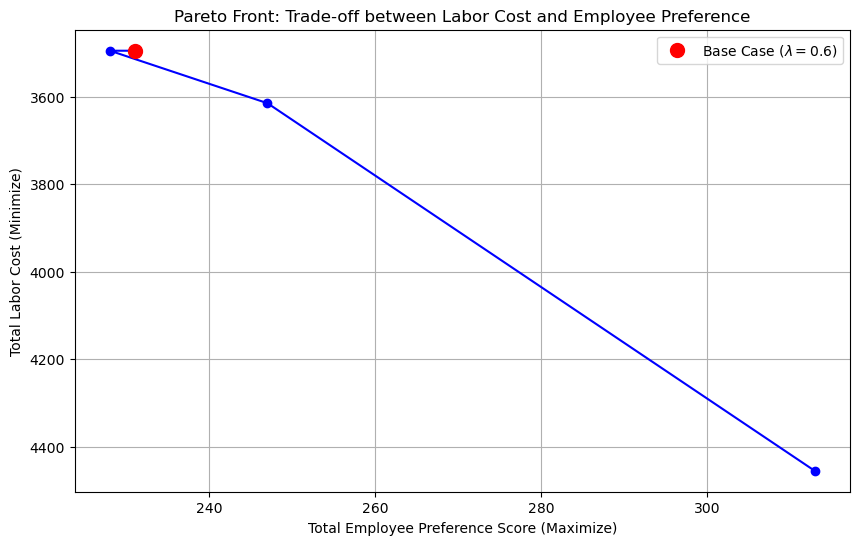


Resource Utilization Analysis


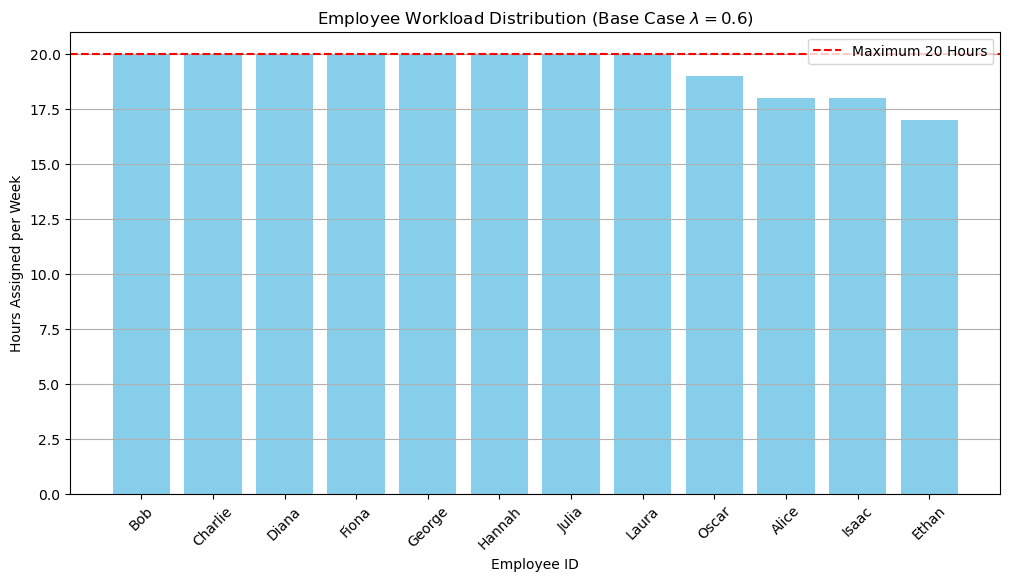


Shift Coverage Slack Analysis

Required Staff vs. Assigned Staff (Base Case)
             Shift       Role  Required  Assigned  Slack Binding
     Friday 7-11AM    Cashier         1       2.0    1.0      No
   Monday 11AM-3PM    Cashier         1       2.0    1.0      No
   Saturday 7-11AM  Food Prep         1       2.0    1.0      No
   Saturday 7-12AM    Cashier         1       2.0    1.0      No
     Sunday 7-11AM  Food Prep         1       2.0    1.0      No
     Sunday 7-12AM    Cashier         1       2.0    1.0      No
   Friday 11AM-3PM    Barista         2       2.0    0.0     Yes
   Friday 11AM-3PM    Cashier         1       1.0    0.0     Yes
   Friday 11AM-3PM Shift Lead         1       1.0    0.0     Yes
      Friday 3-7PM    Barista         1       1.0    0.0     Yes
      Friday 3-7PM    Cashier         1       1.0    0.0     Yes
      Friday 3-7PM Shift Lead         1       1.0    0.0     Yes
      Friday 3-7PM    Cleaner         1       1.0    0.0     Yes
     Friday 

In [16]:
if model.status == GRB.OPTIMAL:
    # Extract solution and calculate metrics
    schedule = []
    
    # Calculate costs and total preference for the optimal solution
    total_labor_cost = total_cost.getValue()
    total_preference_score = total_preference.getValue()

    for emp_name in employees:
        for shift in shifts:
            if x[emp_name, shift].X > 0.5:
                schedule.append({
                    'Employee': emp_name,
                    'Shift': shift,
                    'Day': shift.split()[0],
                    'Time': shift.split()[1],
                    'Hours': shift_hours[shift],
                    'Wage': employees[emp_name]['wage'],
                    'Cost': employees[emp_name]['wage'] * shift_hours[shift],
                    'Preference': preferences[emp_name][shift],
                    'Skills': ', '.join(employees[emp_name]['skills'])
                })

    df_schedule = pd.DataFrame(schedule)
    
    # Calculate Employee Stats
    employee_stats = df_schedule.groupby('Employee').agg({
        'Hours': 'sum',
        'Cost': 'sum',
        'Shift': 'count',
        'Preference': 'mean'
    }).round(2)
    employee_stats.columns = ['Total Hours', 'Total Cost', 'Shifts Assigned', 'Avg Preference']
    employee_stats = employee_stats.sort_values('Total Hours', ascending=False)
    
    # Comprehensive Schedule Table (For Reporting)
    
    df_pivot = df_schedule.pivot_table(
        index='Employee', 
        columns='Shift', 
        values='Time', 
        # Display the time slot and the preference score (P:X) in the cell
        aggfunc=lambda x: f"{x.iloc[0]} (P:{df_schedule.loc[x.index, 'Preference'].iloc[0]})",
        fill_value='OFF'
    )
    
    # Sort columns by Day
    df_pivot = df_pivot.reindex(columns=shifts)
    
    # Merge with Total Hours stats
    df_final_schedule = df_pivot.merge(
        employee_stats[['Total Hours', 'Total Cost', 'Avg Preference']], 
        left_index=True, 
        right_index=True
    ).sort_values(by='Total Hours', ascending=False)
    
    
    print("FINAL OPTIMAL EMPLOYEE SCHEDULE (Base Case: λ=0.6)")
    
    print(f"\nTotal Labor Cost: ${total_labor_cost:.2f}")
    print(f"Total Employee Satisfaction Score (Total Preference): {total_preference_score:.0f}")
    print(f"Optimal Objective Value: {model.ObjVal:.2f}")
    
    print("\n--- DETAILED WEEKLY SCHEDULE (Assignment & Preference) ---")
    print("Each cell shows: Time Slot (P: Preference Score)")
    print(df_final_schedule.to_string())
    

    print("\n\nPOST-OPTIMALITY ANALYSIS")
    
    # Sensitivity Analysis and Pareto Front Generation
    
    LAMBDA_VALUES = np.linspace(0.0, 1.0, 11) 
    pareto_data = []
    
    print("\n Sensitivity Analysis and Pareto Front Generation")
    
    model.setParam('OutputFlag', 0)
    
    for lam in LAMBDA_VALUES:
        model.setObjective(
            lam * total_cost - (1 - lam) * total_preference, 
            GRB.MINIMIZE
        )
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            pareto_data.append({
                'Lambda': lam,
                'Total_Cost': total_cost.getValue(),
                'Total_Preference': total_preference.getValue()
            })
    
    # set objective back to base case
    model.setParam('OutputFlag', 1)
    # ensure final output data corresponds to the base case (lambda=0.6)
    model.setObjective(lambda_param * total_cost - (1 - lambda_param) * total_preference, GRB.MINIMIZE)
    model.optimize() 

    Pareto_DF = pd.DataFrame(pareto_data)
    
    print("\n### Pareto Front Data Table")
    print(Pareto_DF.to_string(index=False))

    # Pareto Front plot 
    plt.figure(figsize=(10, 6))
    plt.plot(Pareto_DF['Total_Preference'], Pareto_DF['Total_Cost'], marker='o', linestyle='-', color='b')
    
    base_case = Pareto_DF[Pareto_DF['Lambda'].round(1) == 0.6]
    if not base_case.empty:
        plt.plot(base_case['Total_Preference'], base_case['Total_Cost'], 'ro', markersize=10, label=f'Base Case ($\lambda=0.6$)')

    plt.title('Pareto Front: Trade-off between Labor Cost and Employee Preference')
    plt.xlabel('Total Employee Preference Score (Maximize)')
    plt.ylabel('Total Labor Cost (Minimize)')
    plt.grid(True)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.show() 


    # Resource Utilization Analysis (Workload Plot)
    Total_Hours_e = employee_stats.reset_index()[['Employee', 'Total Hours']]
    Total_Hours_e.columns = ['Employee', 'Total_Hours'] # Reformat DF created earlier

    # Max hours is 20 for all employees
    MAX_HOURS = employees[employee_names[0]]['max_hours'] 
    
    print("\nResource Utilization Analysis")
    plt.figure(figsize=(12, 6))
    plt.bar(Total_Hours_e['Employee'], Total_Hours_e['Total_Hours'], color='skyblue')
    plt.axhline(y=MAX_HOURS, color='r', linestyle='--', label=f'Maximum {MAX_HOURS} Hours')
    
    plt.title(f'Employee Workload Distribution (Base Case $\lambda={lambda_param}$)')
    plt.xlabel('Employee ID')
    plt.ylabel('Hours Assigned per Week')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.show() 
    
    
    # Shift Coverage Slack Analysis
    print("\nShift Coverage Slack Analysis")
    
    slack_data = []

    for shift in shifts:
        for skill in skills:
            required = shift_requirements[shift].get(skill, 0)
            if required > 0:
                # Sum assigned variables (x[e,s]) only for employees with the required skill
                assigned = sum(
                    x[emp_name, shift].X 
                    for emp_name in employees 
                    if skill in employees[emp_name]['skills']
                )
                
                slack = assigned - required
                
                slack_data.append({
                    'Shift': shift,
                    'Role': skill,
                    'Required': required,
                    'Assigned': assigned,
                    'Slack': slack,
                    'Binding': 'Yes' if slack < 0.01 else 'No'
                })

    Slack_DF = pd.DataFrame(slack_data).sort_values(by=['Binding', 'Slack', 'Shift'])
    
    print("\nRequired Staff vs. Assigned Staff (Base Case)")
    print(Slack_DF.to_string(index=False))
    
    print("ANALYSIS COMPLETE")


Slack_DF.to_csv("Slack_DF.csv")

In [18]:
if model.status == GRB.OPTIMAL:
    # Extract solution and calculate metrics
    schedule = []
    
    total_labor_cost = total_cost.getValue()
    total_preference_score = total_preference.getValue()

    for emp_name in employees:
        for shift in shifts:
            if x[emp_name, shift].X > 0.5:
                schedule.append({
                    'Employee': emp_name,
                    'Shift': shift,
                    'Day': shift.split()[0],
                    'Time': shift.split()[1],
                    'Hours': shift_hours[shift],
                    'Wage': employees[emp_name]['wage'],
                    'Cost': employees[emp_name]['wage'] * shift_hours[shift],
                    'Preference': preferences[emp_name][shift],
                    'Skills': ', '.join(employees[emp_name]['skills'])
                })

    df_schedule = pd.DataFrame(schedule)
    
    # Employee-level stats
    employee_stats = df_schedule.groupby('Employee').agg({
        'Hours': 'sum',
        'Cost': 'sum',
        'Shift': 'count',
        'Preference': 'mean'
    }).round(2)

    employee_stats.columns = ['Total Hours', 'Total Cost', 'Shifts Assigned', 'Avg Preference']
    employee_stats = employee_stats.sort_values('Total Hours', ascending=False)
    
    # Format "Time (P:X)" for pivot
    df_schedule["Cell"] = df_schedule.apply(
        lambda row: f"{row['Time']} (P:{int(row['Preference'])})",
        axis=1
    )

    # Create pivot table: Employee × (Day, Time)
    df_pivot = df_schedule.pivot_table(
        index="Employee",
        columns=["Day", "Time"],
        values="Cell",
        aggfunc="first",
        fill_value="OFF"
    )

    # Order columns
    day_order = {day: i for i, day in enumerate(days)}
    time_order = {slot_name: i for i, (slot_name, _, _, _) in enumerate(time_slots)}

    ordered_cols = sorted(
        df_pivot.columns,
        key=lambda c: (day_order.get(c[0], 999), time_order.get(c[1], 999))
    )

    df_pivot = df_pivot[ordered_cols]

    # Add summary columns
    df_pivot[("Summary", "Total Hours")] = employee_stats["Total Hours"]
    df_pivot[("Summary", "Total Cost")] = employee_stats["Total Cost"]
    df_pivot[("Summary", "Avg Preference")] = employee_stats["Avg Preference"]

    main_cols = [c for c in df_pivot.columns if c[0] != "Summary"]
    summary_cols = [c for c in df_pivot.columns if c[0] == "Summary"]

    df_pivot = df_pivot[main_cols + summary_cols]

    df_final_schedule = df_pivot.sort_values(("Summary", "Total Hours"), ascending=False)

    # Flatten headers
    new_cols = []
    for col in df_final_schedule.columns:
        if col[0] == "Summary":
            new_cols.append(col[1])
        else:
            new_cols.append(f"{col[0]}\n{col[1]}")
    df_final_schedule.columns = new_cols

    # ---------------------------
    # PRINT MASTER SUMMARY TABLE
    # ---------------------------

    print("FINAL OPTIMAL EMPLOYEE SCHEDULE (Base Case: λ=0.6)")
    print(f"\nTotal Labor Cost: ${total_labor_cost:.2f}")
    print(f"Total Employee Satisfaction Score (Total Preference): {total_preference_score:.0f}")
    print(f"Optimal Objective Value: {model.ObjVal:.2f}")

    print("\n--- DETAILED WEEKLY SCHEDULE (Assignment & Preference) ---")
    print("Each cell shows: Time Slot (P: Preference Score)")
    print(df_final_schedule.to_string())

    # ---------------------------
    # HUMAN-READABLE DAY-BY-DAY TABLES
    # ---------------------------

    print("\n--- FORMATTED WEEKLY SCHEDULE (Human-Readable) ---")

    day_columns = [c for c in df_final_schedule.columns if '\n' in c]
    day_map = {}

    for col in day_columns:
        day, time = col.split('\n')
        day_map.setdefault(day, {})[time] = col

    for day in days:
        if day not in day_map:
            continue

        print(f"\n===================== {day.upper()} =====================\n")

        time_slots_sorted = ["7-11AM", "11AM-3PM", "3-7PM", "7-12AM"]
        use_cols = [day_map[day].get(t) for t in time_slots_sorted if t in day_map[day]]

        day_table = df_final_schedule[
            use_cols + ["Total Hours", "Avg Preference"]
        ].copy()

        rename_map = {day_map[day][t]: t for t in day_map[day]}
        day_table = day_table.rename(columns=rename_map)

        print(day_table.to_string())

    # ---------------------------
    # EXPORT TO EXCEL (openpyxl)
    # ---------------------------

    print("\nCreating Excel schedule...")

    writer = pd.ExcelWriter("Weekly_Schedule.xlsx", engine="openpyxl")

    for day in days:
        if day not in day_map:
            continue

        time_slots_sorted = ["7-11AM", "11AM-3PM", "3-7PM", "7-12AM"]
        use_cols = [day_map[day].get(t) for t in time_slots_sorted if t in day_map[day]]

        day_table = df_final_schedule[
            use_cols + ["Total Hours", "Avg Preference"]
        ].copy()

        rename_map = {day_map[day][t]: t for t in day_map[day]}
        day_table = day_table.rename(columns=rename_map)

        sheet_name = day
        day_table.to_excel(writer, sheet_name=sheet_name, index=True)

        sheet = writer.sheets[sheet_name]

        # Insert title
        sheet.insert_rows(1)
        sheet["A1"] = f"{day} Schedule"

        # Bold title
        from openpyxl.styles import Font
        sheet["A1"].font = Font(bold=True, size=14)

        # Auto column widths
        for col in sheet.columns:
            max_len = 0
            column_letter = col[0].column_letter
            for cell in col:
                try:
                    max_len = max(max_len, len(str(cell.value)))
                except:
                    pass
            sheet.column_dimensions[column_letter].width = max_len + 3

    writer.close()

    print("Excel file 'Weekly_Schedule.xlsx' created successfully!")


FINAL OPTIMAL EMPLOYEE SCHEDULE (Base Case: λ=0.6)

Total Labor Cost: $3495.00
Total Employee Satisfaction Score (Total Preference): 231
Optimal Objective Value: 2004.60

--- DETAILED WEEKLY SCHEDULE (Assignment & Preference) ---
Each cell shows: Time Slot (P: Preference Score)
         Monday\n7-11AM Monday\n11AM-3PM Monday\n3-7PM Monday\n7-12AM Tuesday\n7-11AM Tuesday\n11AM-3PM Tuesday\n3-7PM Tuesday\n7-12AM Wednesday\n7-11AM Wednesday\n11AM-3PM Wednesday\n3-7PM Wednesday\n7-12AM Thursday\n7-11AM Thursday\n11AM-3PM Thursday\n3-7PM Thursday\n7-12AM Friday\n7-11AM Friday\n11AM-3PM Friday\n3-7PM Friday\n7-12AM Saturday\n7-11AM Saturday\n11AM-3PM Saturday\n3-7PM Saturday\n7-12AM Sunday\n7-11AM Sunday\n11AM-3PM Sunday\n3-7PM Sunday\n7-12AM  Total Hours  Total Cost  Avg Preference
Employee                                                                                                                                                                                                            

<Figure size 1200x600 with 0 Axes>

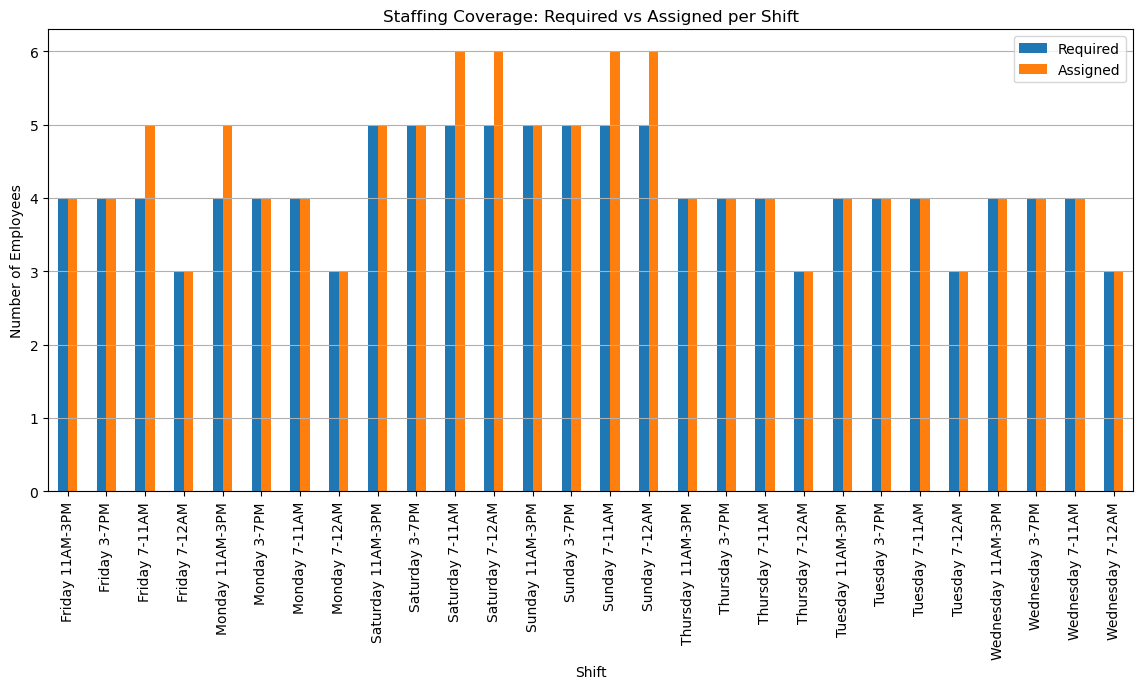

In [17]:
# SHIFT STAFFING COVERAGE PLOT

coverage = []

for shift in shifts:
    for skill in skills:
        required = shift_requirements[shift].get(skill, 0)
        if required > 0:
            assigned = sum(
                x[emp, shift].X
                for emp in employees
                if skill in employees[emp]["skills"]
            )
            coverage.append({
                "Shift": shift,
                "Skill": skill,
                "Required": required,
                "Assigned": assigned
            })

df_cov = pd.DataFrame(coverage)

# Aggregate by shift (sum all skills)
df_cov_shift = df_cov.groupby("Shift")[["Required", "Assigned"]].sum()

plt.figure(figsize=(12,6))
df_cov_shift.plot(kind="bar", figsize=(14,6))
plt.title("Staffing Coverage: Required vs Assigned per Shift")
plt.ylabel("Number of Employees")
plt.xlabel("Shift")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()
